In [43]:
import matplotlib.pyplot as plt
import cv2
from glob import glob
from collections import Counter, OrderedDict
from copy import deepcopy
import os
from PIL import Image

In [53]:
with open('HW1_dataset/classes.names', 'r') as labels_file:
    labels = labels_file.readlines()
labels = [l.strip().replace("_", ' ') for l in labels]

In [62]:
label_to_idx = {l: i for i, l in enumerate(labels)}
idx_to_label = {i: l for i, l in enumerate(labels)}

idx_to_color_HEX = {0: "#1f77b4",
                    1: "#ff7f0e",
                    2: "#2ca02c",
                    3: "#d62728",
                    4: "#9467bd",
                    5: "#8c564b",
                    6: "#e377c2",
                    7: "#7f7f7f"}

idx_to_color_RGB = {0: (31, 119, 180),
                    1: (255, 127, 14),
                    2: (44, 160, 44),
                    3: (214, 39, 40),
                    4: (148, 103, 189),
                    5: (140, 86, 75),
                    6: (227, 119, 194),
                    7: (127, 127, 127)}

In [63]:
train_files = glob('arranged_dataset/train/labels/*.txt')

In [64]:
tags = []
for f_name in train_files:
    with open(f_name, 'r') as f:
        lines = f.readlines()
        for line in lines:
            tag = int(line.split()[0])
            tags.append(idx_to_label[tag])

In [65]:
labels_count = Counter(tags)

In [66]:
for l in labels:
    if l not in labels_count:
        labels_count[l] = 0

In [67]:
ordered_counter = OrderedDict()

for l in labels:
    ordered_counter[l] = labels_count[l]

In [68]:
ordered_counter

OrderedDict([('Right Scissors', 186),
             ('Left Scissors', 2),
             ('Right Needle driver', 532),
             ('Left Needle driver', 32),
             ('Right Forceps', 0),
             ('Left Forceps', 255),
             ('Right Empty', 65),
             ('Left Empty', 502)])

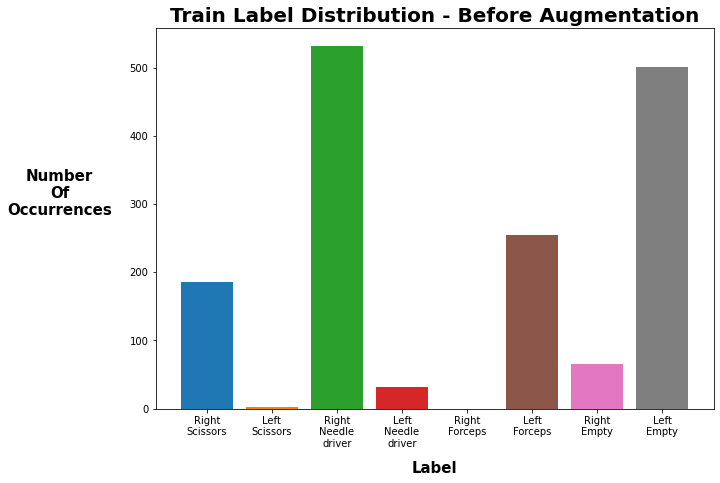

In [69]:
plt.figure(figsize=(10, 7))
plt.bar([desc.replace(' ', '\n') for desc in ordered_counter.keys()], ordered_counter.values(), color=idx_to_color_HEX.values())
plt.xlabel('Label', fontweight='bold', fontsize=15, labelpad=12)
plt.ylabel('Number\nOf\nOccurrences', fontweight='bold', fontsize=15, rotation=0, labelpad=70)
plt.title('Train Label Distribution - Before Augmentation', fontweight='bold', fontsize=20)
plt.show()

In [17]:
def flip_yolo(yolo_format):
    label, x_center, y_center, w, h = yolo_format
    if label % 2 == 0:
        label += 1
    else:
        label -= 1
    return [label, 1 - x_center, y_center, w, h]

In [23]:
def perform_flip_util(img, yolo_formats):
    new_img = cv2.flip(deepcopy(img), 1)
    yolo_formats = [flip_yolo(yolo_format) for yolo_format in yolo_formats]
    return new_img, yolo_formats

In [21]:
def create_label_file(file_path, formats):
    with open(file_path, 'w') as f:
        for i, format in enumerate(formats):
            if i != 0:
                f.write('\n')
            f.write(' '.join([str(num) for num in format]))

In [93]:
def flip_single_image(name):
    image_path = f'arranged_dataset/valid/images/{name}.jpg'
    format_path = f'arranged_dataset/valid/labels/{name}.txt'
    img = cv2.imread(image_path)
    with open(format_path, 'r') as format_file:
        formats = format_file.readlines()
    formats = [f.strip().split() for f in formats]
    formats = [[int(n) if i == 0 else float(n) for i, n in enumerate(f)] for f in formats]
    augmented_img, augmented_formats = perform_flip_util(img, formats)

    images_directory = "augmented_dataset_with_valid/valid/images"
    labels_directory = "augmented_dataset_with_valid/valid/labels"

    if not os.path.exists(images_directory):
        os.makedirs(images_directory)

    if not os.path.exists(labels_directory):
        os.makedirs(labels_directory)

    new_image_path = f'augmented_dataset_with_valid/valid/images/{name}.jpg'
    augmented_image_path = f'augmented_dataset_with_valid/valid/images/{name}_flip.jpg'
    new_format_path = f'augmented_dataset_with_valid/valid/labels/{name}.txt'
    augmented_format_path = f'augmented_dataset_with_valid/valid/labels/{name}_flip.txt'

    create_label_file(new_format_path, formats)
    create_label_file(augmented_format_path, augmented_formats)
    cv2.imwrite(new_image_path, img)
    cv2.imwrite(augmented_image_path, augmented_img)



In [40]:
for train_file in train_files:
    name = os.path.basename(train_file[:-4])
    flip_single_image(name)

  0%|          | 0/790 [00:00<?, ?it/s]

In [94]:
valid_files = glob('arranged_dataset/valid/labels/*.txt')
for valid_file in valid_files:
    name = os.path.basename(valid_file[:-4])
    flip_single_image(name)

In [48]:
def yolo_to_bbox(img, yolo_format):
    h, w, _ = img.shape
    w_half_len = (yolo_format[3] * w) / 2
    h_half_len = (yolo_format[4] * h) / 2
    xmin = int((yolo_format[1] * w) - w_half_len)
    ymin = int((yolo_format[2] * h) - h_half_len)
    xmax = int((yolo_format[1] * w) + w_half_len)
    ymax = int((yolo_format[2] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax]


def draw_bboxes(img, classes, bboxes):
    for cls, box in zip(classes, bboxes):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), idx_to_color_RGB[cls], 2)


def draw_labels(img, classes, bboxes):
    for cls, box in zip(classes, bboxes):
        xmin, ymin, xmax, ymax = box
        label = idx_to_label[cls]

        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)

        img = cv2.rectangle(img, (xmin - 1, ymin - 20), (xmin + w, ymin - 1), idx_to_color_RGB[cls], -1)
        img = cv2.putText(img, label, (xmin, ymin - 5),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)


def create_bbox(img, img_name):
    new_img = deepcopy(img)
    with open(f"augmented_dataset/train/labels/{img_name}.txt", 'r') as f:
        lines = f.readlines()
    lines = [line.strip().split() for line in lines]
    classes = []
    bboxes_yolo = []
    bboxes = []
    for line in lines:
        classes.append(int(line[0]))
        bboxes_yolo.append([classes[-1]])
        for num_str in line[1:]:
            bboxes_yolo[-1].append(float(num_str))
        bboxes.append(yolo_to_bbox(img, bboxes_yolo[-1]))

    draw_bboxes(new_img, classes, bboxes)
    draw_labels(new_img, classes, bboxes)

    return new_img

In [50]:
def convert_cv2_to_pil(cv_image):
    img = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

def image_grid(cv_images, rows, cols):
    images = [convert_cv2_to_pil(img) for img in cv_images]
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))

    for i, img in enumerate(images):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [49]:
example_name = "P016_balloon1_1188"
example = cv2.imread(f'augmented_dataset/train/images/{example_name}.jpg')
example_augmented = cv2.imread(f'augmented_dataset/train/images/{example_name}_flip.jpg')
bboxed_example = create_bbox(example, example_name)
bboxed_example_augmented = create_bbox(example_augmented, f"{example_name}_flip")

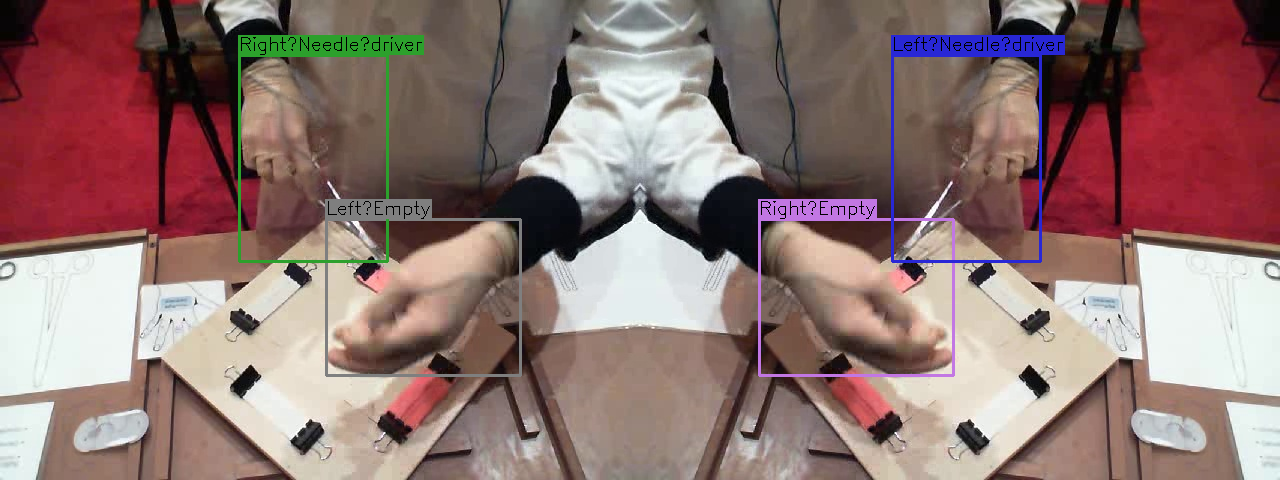

In [52]:
grid = image_grid([bboxed_example, bboxed_example_augmented], 1, 2)
grid

In [81]:
import random
os.path.basename(random.choice(train_files))[:-4]

'P022_balloon1_988'

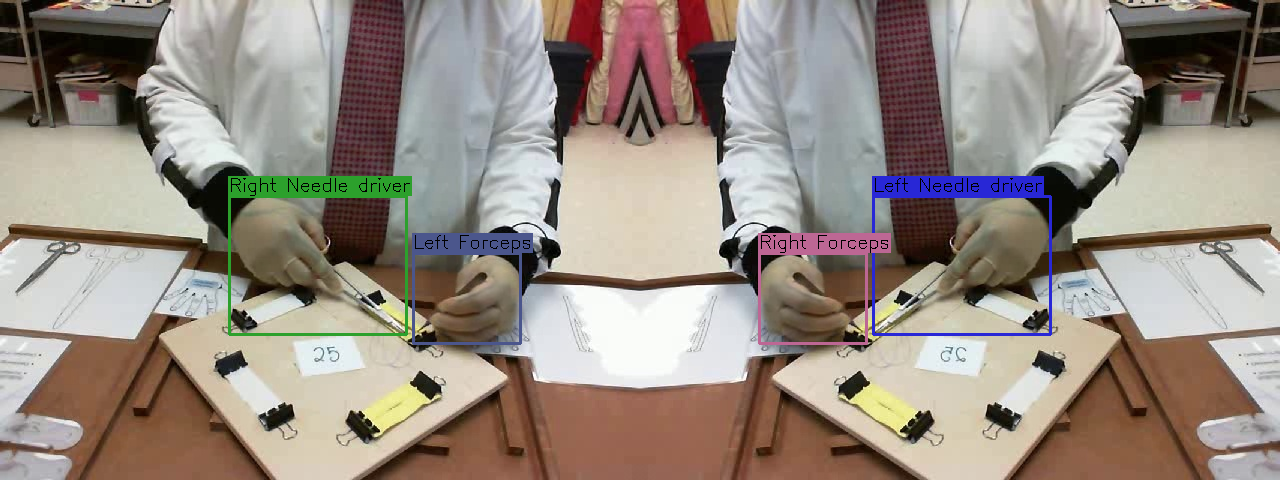

In [89]:
example_name = os.path.basename(random.choice(train_files))[:-4]
example = cv2.imread(f'augmented_dataset/train/images/{example_name}.jpg')
example_augmented = cv2.imread(f'augmented_dataset/train/images/{example_name}_flip.jpg')
bboxed_example = create_bbox(example, example_name)
bboxed_example_augmented = create_bbox(example_augmented, f"{example_name}_flip")
grid = image_grid([bboxed_example, bboxed_example_augmented], 1, 2)
grid

In [72]:
new_train_files = glob('augmented_dataset/train/labels/*.txt')


In [73]:
tags = []
for f_name in new_train_files:
    with open(f_name, 'r') as f:
        lines = f.readlines()
        for line in lines:
            tag = int(line.split()[0])
            tags.append(idx_to_label[tag])
labels_count = Counter(tags)
for l in labels:
    if l not in labels_count:
        labels_count[l] = 0
ordered_counter = OrderedDict()

for l in labels:
    ordered_counter[l] = labels_count[l]
ordered_counter

OrderedDict([('Right Scissors', 188),
             ('Left Scissors', 188),
             ('Right Needle driver', 564),
             ('Left Needle driver', 564),
             ('Right Forceps', 255),
             ('Left Forceps', 255),
             ('Right Empty', 567),
             ('Left Empty', 567)])

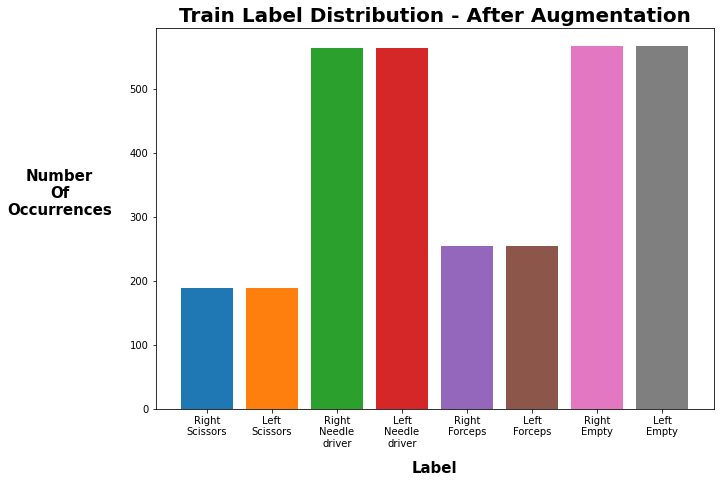

In [76]:
plt.figure(figsize=(10, 7))  # width:20, height:3
plt.bar([desc.replace(' ', '\n') for desc in ordered_counter.keys()], ordered_counter.values(), color=idx_to_color_HEX.values())
plt.xlabel('Label', fontweight='bold', fontsize=15, labelpad=12)
plt.ylabel('Number\nOf\nOccurrences', fontweight='bold', fontsize=15, rotation=0, labelpad=70)
plt.title('Train Label Distribution - After Augmentation', fontweight='bold', fontsize=20)
plt.show()